# **Imports**

In [1]:
# Een manier om te checken of je in Google Colab werkt of niet.
# Als je in Google Colab werkt, moet de data uit Google Drive worden geladen, dus dan moet de code iets anders zijn
try:
    import google.colab
    colab = True
except:
    colab = False

if colab:
    from google.colab import drive
    from google.colab import files
    drive.mount('/content/drive')

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import time
import requests
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from geopy.geocoders import Nominatim
from scipy.stats import linregress
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from joblib import Parallel, delayed

# De Tensorflow versie moet <2.11 zijn om de GPU te gebruiken op native Windows!
import tensorflow as tf
import keras
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

pd.set_option('display.max_columns', None)

Mounted at /content/drive


# **Functies**

### Algemeen

In [2]:
def df_to_dfCity(df: pd.DataFrame, city: str) -> pd.DataFrame:
    """Returnt een DataFrame met alleen huizen uit de geselecteerde stad"""
    return df.loc[df['address_city'] == city].reset_index(drop=True)

def km_to_coordinates(km: float) -> float:
    """Om een afstand in kilometers om te rekenen naar coordinaten"""
    return km / (111 + 1/9)

def negative_sqrt(x):
    """om de squared bias te berekenen en de min niet weg te laten vallen"""
    if x < 0:
        return -math.sqrt(abs(x))
    else:
        return math.sqrt(x)

def delete_certain_values(df, column_name, value):
    """Om rijen met specifieke waarden die niet kunnen kloppen te verwijderen"""
    index_to_drop = df[df[column_name] == value].index
    df.drop(labels=index_to_drop, axis=0, inplace=True)
    return df

def df_percentile(df: pd.DataFrame, lower: float, upper: float) -> pd.DataFrame:
    """Om uitschieters niet mee te nemen, mochten we dat willen"""
    lower_percentile = df['askingprice'].quantile(lower)
    upper_percentile = df['askingprice'].quantile(upper)
    df_percent = df[df['askingprice'].between(lower_percentile, upper_percentile)]
    return df_percent

def split_data(df: pd.DataFrame, ratio: float) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Split de DataFrame in twee willekeurig geschudde DataFrames in de ingevoerde ratio"""
    df_shuffled = df.sample(frac=1).reset_index(drop=True) # Dit schudt de data willekeurig
    split_index = round(len(df) * ratio) # Dit berekent de index waarop we de DataFrame moeten splitten (afgerond)

    train_set = df_shuffled[:split_index]
    test_set = df_shuffled[split_index:]
    return train_set, test_set

### Geocoding

In [3]:
# Te sloom om om een grote dataset te doen en er is een limiet op het aantal requests achter elkaar
def df_with_location(df, city=''):
    """Voegt missende en extra locatiegegevens toe aan een DataFrame"""
    if city:
       df = df_to_dfCity(df, city)

    def row_with_location_columns(row: pd.Series) -> pd.DataFrame:
        location = geolocator.reverse((row['geodata_latitude'], row['geodata_longitude']))
        time.sleep(1) # om te voorkomen dat er teveel requests achter elkaar worden verstuurd
        address = location.raw['address']
        row['building_type'] = location.raw.get('type')
        if math.isnan(row['address_house_number']):
            row['address_house_number'] = address.get('house_number')
        if pd.isnull(row['address_street']):
            row['address_street'] = address.get('road'),
        row['neighbourhood'] = address.get('neighbourhood')
        row['suburb'] = address.get('suburb')
        row['municipality'] = address.get('municipality')
        row['state'] = address.get('state')
        if pd.isnull(['address_zip_code']):
            row['address_zip_code'] = address.get('postcode')
        return row

    df = df.copy()
    df.dropna(subset=['geodata_latitude', 'geodata_longitude'], inplace=True)
    geolocator = Nominatim(user_agent='my-app')
    df_with_coordinates = df.apply(lambda row: row_with_location_columns(row), axis=1)

    return df_with_coordinates

### Alternatieve data

In [4]:
def breakIn_stats(df, to_csv=False):
    """Haalt data over inbraken van de laatste drie maanden per postcode van politie.nl"""
    all_cities = pd.unique(df['address_city'].values.ravel())
    strings_cities = [city for city in all_cities if isinstance(city, str)]
    cities = list(map(str.lower, strings_cities))

    crime_data = pd.DataFrame()

    for city in cities:
        try:
            url = f'https://www.politie.nl/mijn-buurt/misdaad-in-kaart/lijst?geoquery={city}&distance=25&pageSize=500'
            response = requests.get(url)
            df = pd.read_html(response.content)[0]
            df['City'] = city.capitalize()
            crime_data = pd.concat([crime_data, df])
        except: pass

    crime_data.reset_index(drop=True, inplace=True)
    if to_csv:
        crime_data.to_csv(f'woninginbraken_{df}.csv', index=False)
    return crime_data

def crimes_per_postcode(df_crime):
    """Telt het aantal inbraken en pogingen tot inbraak per postcode en zet in DataFrame"""
    postcode_counts = df_crime['Postcodegebied'].value_counts().reset_index()
    postcode_counts.columns = ['Postcodegebied', 'number_of_crimes']
    return postcode_counts

def concat_crimestats(df, postcode_counts):
    """Voegt een kolom toe aan de DataFrame met het aantal inbraken op de postcode"""
    postcode_counts['Postcodegebied'] = postcode_counts['Postcodegebied'].astype(str)
    df['address_zip_code'] = df['address_zip_code'].astype(str)

    # Voeg samen op basis van de postcode (de data van politie.nl had alleen de cijfers van de postcode)
    merged_df = pd.merge(df, postcode_counts, how='left', left_on=df['address_zip_code'].str[:4], right_on=postcode_counts['Postcodegebied'], suffixes=('', '_crime'))
    # Als er geen inbraken staan, betekent het dat er 0 inbraken en pogingen tot inbraak waren



    merged_df.fillna(0, inplace=True) # NaN van maken als geen postcode!!!



    # Drop de overbodige kolommen
    merged_df.drop(['key_0', 'Postcodegebied'], axis=1, inplace=True)

    return merged_df

### Visualiseren van data

In [5]:
def plot_coordinates(df) -> None:
  """Maakt een scatterplot van alle coordinaten"""
  latitude = df['geodata_latitude'].tolist()
  longitude = df['geodata_longitude'].tolist()
  plt.figure(figsize=(10, 7))
  plt.scatter(longitude, latitude, s=1) # s bepaalt hoe groot de punten zijn
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')
  plt.title('Coordinaten in een scatter plot')
  plt.grid(True) # Voegt rasterlijnen toe

  plt.show()

def plot_price_per_livingarea(df : pd.DataFrame, city: str, poly_degree=2) -> None:
  """Plot de relatie tussen de prijs en het woonoppervlakte"""
  if city: df = df_to_dfCity(df, city)
  else: df = df.groupby('living_area')['askingprice'].mean().reset_index()

  trace = go.Scatter(x=df['living_area'], y=df['askingprice'], mode='markers', name='Data')

  # polynomial regression met poly_degree=2
  x = df['living_area']
  y = df['askingprice']
  weights = np.polyfit(x, y, poly_degree) # ndarray from w_poly_degree to w_0
  print(f'Weights (descending) = {weights}')
  f = np.poly1d(weights) # w0 + w1*x + w2*x**2 for the correct poly_degree
  x_sorted = x.sort_values()
  y_new = f(x_sorted)
  trace_fit = go.Scatter(x=x_sorted, y=y_new, mode='lines', name='Fit')


  layout = go.Layout(
    title=f'Prijs tegenover oppervlakte - {city}' if city else f'Prijs tegenover oppervlakte - Land (geaggrageerd)',
    xaxis=dict(title='Woonoppervlakte (m\u00b2)', range=[0, 1000]),
    yaxis=dict(title='Prijs (euro\'s)', range=[0, 10_000_000]),
    width=700,
    height=700
  )

  fig = go.Figure(data=[trace, trace_fit], layout=layout)
  fig.show()

def plot_average_price_per_date(df: pd.DataFrame, city='') -> None:
  """Plot de gemiddelde prijs per referentiedatum"""
  if city:
    df = df_to_dfCity(df, city)

  average_price_per_date = df.groupby('referenceDate')['price_per_m2'].mean().reset_index()

  trace = go.Scatter(x=average_price_per_date['referenceDate'], y=average_price_per_date['price_per_m2'], mode='markers+lines')

  layout = go.Layout(
      title=f'Average Price over Reference Date in {city}' if city else 'Average Price over Reference Date in entire country',
      xaxis=dict(title='Reference Date'),
      yaxis=dict(title='Average Price (euros)'),
      width=1000,
      height=500
  )

  fig = go.Figure(data=[trace], layout=layout)

  fig.show()

def visualise_data(heatmap_data=True, price_per_living_area_plot=True, coordinates_plot=True, df_location=True, average_price_per_date_plot=True):
  """Laat visualisaties zien van een aantal eerder gemaakte functies"""
  if heatmap_data:
    sns.heatmap(df_koop.corr(numeric_only=True), cmap='cool')
    plt.title('Correlatie tussen features')
    plt.show()
  if price_per_living_area_plot:
    plot_price_per_livingarea(df_koop, 'Rotterdam')
    print()
  if coordinates_plot:
    plot_coordinates(df)
    print()
  if df_location:
    print('Voorbeeld van welke kolommen geocoding toevoegt:')
    try: display(df_with_location(df_koop, 'Zijderveld').head(1))
    except: print('Can not make request')
    print()
  if average_price_per_date_plot:
    plot_average_price_per_date(df_koop, 'Rotterdam')
    print()
    plot_average_price_per_date(df_koop)
    print()

## **Machine Learning**

### Nearest Neighbours (zelfgemaakt model)

In [6]:
class NearestNeighboursRegressor:
    """Werkt net zoals een model als sklearn, alleen moet de prijs tussen de features staan"""
    def __init__(self, radius_km=1, bias_reducer=0.99, use_area=True):
        self.radius_coordinates = km_to_coordinates(radius_km)
        self.bias_reducer = bias_reducer
        self.use_area = use_area

    def create_prices_Series(self, df_train, lat_min, lat_max, lon_min, lon_max):
        df_good = df_train[(df_train['geodata_latitude'].between(lat_min, lat_max)) & (df_train['geodata_longitude'].between(lon_min, lon_max))]
        if self.use_area: prices_Series = df_good['price_per_m2']
        else: prices_Series = df_good['askingprice']
        return prices_Series

    def fit(self, X_train, y_train=None):
        self.X_train = X_train

    def predict(self, X_test):
        lats = X_test['geodata_latitude']
        lons = X_test['geodata_longitude']
        min_lats, max_lats = lats - self.radius_coordinates, lats + self.radius_coordinates
        min_lons, max_lons = lons - self.radius_coordinates, lons + self.radius_coordinates

        X_train_sorted = self.X_train.sort_values(by=['geodata_latitude', 'geodata_longitude'])

        prices_Series_column = pd.DataFrame(self.create_prices_Series(X_train_sorted, lat_min, lat_max, lon_min, lon_max).values for (lat_min, lat_max, lon_min, lon_max) in zip(min_lats, max_lats, min_lons, max_lons))
        mean_price_column = prices_Series_column.mean(axis=1)

        if self.use_area: predictions = mean_price_column * X_test['living_area'].reset_index(drop=True) ** self.bias_reducer
        else: predictions = mean_price_column

        return predictions

### Algemeen model

In [7]:
def prepare_features_for_model(df, print_data_cleaning=False, print_amount_of_used_datapoints=False, dropna_all_features=False, living_area=True, land_area=False, number_of_rooms=False, energy_label=False, construction_year=False, renovation=False,
                               property_type=False, number_of_crimes=False, nearestNeighbours=False, ridge=False, decisionTree=False, MLPReg=False, randomForest=False, XGB=False, GBR=False, Bag=False):
  """Verwijdert de rijen met NaN values voor gebruikte features"""

  df = df.copy()

  features = []

  if print_data_cleaning: print(f'Aantal huizen zonder te filteren: {len(df)}')
  if living_area:
    features.append('living_area')
  if land_area:
    if print_data_cleaning: print(f'Zonder data over de tuin: {df["land_area"].isna().sum()}')
    features.append('land_area')
  if number_of_rooms:
    if print_data_cleaning: print(f'Zonder aantal_kamers: {df["number_of_rooms"].isna().sum()}')
    features.append('number_of_rooms')
  if energy_label:
    if print_data_cleaning: print(f'Zonder energie_label: {df["energy_label_numeric"].isna().sum()}')
    features.append('energy_label_numeric')
  if construction_year:
    if print_data_cleaning: print(f'Zonder construction_year: {df["construction_year"].isna().sum()}')
    features.append('construction_year')
  if renovation:
    features.append('renovation_binary')
  if property_type:
    if print_data_cleaning: print(f'Zonder property_type: {df["property_type"].isna().sum()}')
    features.append('property_type_binary')
  if number_of_crimes:
    if print_data_cleaning: print(f'Zonder crime_stats: {df["address_zip_code"].isna().sum()}')
    features.append('address_zip_code')
  if nearestNeighbours:
    if print_data_cleaning: print(f'Zonder nearest-neighbours_prediction: {df["NearestNeighboursRegressor_prediction"].isna().sum()}')
    features.append('NearestNeighboursRegressor_prediction')
  if decisionTree:
    if print_data_cleaning: print(f'Zonder decisionTreeRegressor_prediction: {df["DecisionTreeRegressor_prediction"].isna().sum()}')
    features.append('DecisionTreeRegressor_prediction')
  if ridge:
    if print_data_cleaning: print(f'Zonder LinearRegression_prediction: {df["Ridge_prediction"].isna().sum()}')
    features.append('Ridge_prediction')
  if MLPReg:
    if print_data_cleaning: print(f'Zonder MLPRegression_prediction: {df["MLPRegressor_prediction"].isna().sum()}')
    features.append('MLPRegressor_prediction')
  if randomForest:
    if print_data_cleaning: print(f'Zonder RandomForestRegressor_prediction: {df["RandomForestRegressor_prediction"].isna().sum()}')
    features.append('RandomForestRegressor_prediction')
  if XGB:
    if print_data_cleaning: print(f'Zonder XGBoostingRegressor_prediction: {df["XGBRegressor_prediction"].isna().sum()}')
    features.append('XGBRegressor_prediction')
  if GBR:
    if print_data_cleaning: print(f'Zonder GradientBoostingRegressor_prediction: {df["GradientBoostingRegressor_prediction"].isna().sum()}')
    features.append('GradientBoostingRegressor_prediction')
  if Bag:
    if print_data_cleaning: print(f'Zonder BaggingRegressor_prediction: {df["BaggingRegressor_prediction"].isna().sum()}')
    features.append('BaggingRegressor_prediction')

  if dropna_all_features: df.dropna(subset=['living_area', 'land_area', 'number_of_rooms', 'energy_label', 'construction_year', 'property_type', 'address_zip_code'], inplace=True)
  else: df.dropna(subset=features, inplace=True)

  if number_of_crimes: features = ['number_of_crimes' if f == 'address_zip_code' else f for f in features]

  if print_amount_of_used_datapoints:
    print(f'Aantal huizen na het filteren: {len(df):,}')
    print()

  return df, features

def kFoldCrossValidation_no_parallel(df: pd.DataFrame, model, features: list, k: int, add_columns=False, poly=0, tree_depth=0, epochs=100):
  """Standaard k-fold cross-validation"""
  df_parts = np.array_split(df, k)
  kf = KFold(n_splits=k, shuffle=True)

  total_bias_percentage = 0
  total_abs_error_percentage = 0
  total_squared_error_percentage = 0
  total_r2 = 0

  for train_index, test_index in kf.split(df_parts):
    train_df = pd.concat([df_parts[i] for i in train_index])
    test_df = pd.concat([df_parts[i] for i in test_index])

    X_train = train_df[features]
    y_train = train_df['askingprice']

    X_test = test_df[features]
    y_test = test_df['askingprice']

    if poly:
      poly_features = PolynomialFeatures(poly)
      X_train = poly_features.fit_transform(X_train)
      X_test = poly_features.transform(X_test)

    if isinstance(model, keras.Sequential):
      X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
      X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
      y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
      model.fit(X_train_tensor, y_train_tensor, epochs=epochs, verbose=0)
      y_test_predict = model.predict(X_test_tensor)
      r2 = r2_score(y_test, np.array(y_test_predict).ravel())
      errors = np.array(y_test_predict).ravel() - y_test
    else:
      model.fit(X_train, y_train)
      y_test_predict = model.predict(X_test)
      y_test_predict = np.nan_to_num(y_test_predict, nan=0)
      r2 = r2_score(y_test, y_test_predict)
      errors = np.array(y_test_predict) - y_test

    error_percentages = errors * 100 / y_test
    squared_error_percentages = error_percentages ** 2
    total_bias_percentage += np.mean(error_percentages)
    total_abs_error_percentage += np.mean(abs(error_percentages))
    total_squared_error_percentage += np.mean(squared_error_percentages)
    total_r2 += r2

    if add_columns: df.loc[test_df.index, f'{type(model).__name__}_prediction'] = np.array(y_test_predict)

  if tree_depth:
    plt.figure(figsize=(25, 25))
    tree.plot_tree(model, filled=True, feature_names=features, rounded=True, fontsize=6, max_depth=tree_depth)
    plt.show()
    print()

  mean_bias = total_bias_percentage / k
  mean_abs_error = total_abs_error_percentage / k
  mean_squared_error = total_squared_error_percentage / k
  root_mean_squared_error = np.sqrt(mean_squared_error)
  r2 = total_r2 / k

  return mean_bias, mean_abs_error, root_mean_squared_error, r2, df

def train_and_predict(train_index, test_index, df_parts, features, poly, model, add_columns):
  """Helper functie om parallel uitvoeren voor k-fold cross-validation mogelijk te maken"""
  train_df = pd.concat([df_parts[i] for i in train_index])
  test_df = pd.concat([df_parts[i] for i in test_index])

  X_train = train_df[features]
  y_train = train_df['askingprice']

  X_test = test_df[features]
  y_test = test_df['askingprice']

  if poly:
    poly_features = PolynomialFeatures(poly)
    X_train = poly_features.fit_transform(X_train)
    X_test = poly_features.transform(X_test)

  model.fit(X_train, y_train)

  y_test_predict = model.predict(X_test)
  y_test_predict = np.nan_to_num(y_test_predict, nan=0)

  r2 = r2_score(y_test, y_test_predict)
  errors = np.array(y_test_predict) - y_test
  error_percentages = errors * 100 / y_test
  squared_error_percentages = error_percentages ** 2
  total_bias_percentage = np.mean(error_percentages)
  total_abs_error_percentage = np.mean(np.abs(error_percentages))
  total_squared_error_percentage = np.mean(squared_error_percentages)

  if add_columns: test_df[f'{type(model).__name__}_prediction'] = np.array(y_test_predict)

  return total_bias_percentage, total_abs_error_percentage, total_squared_error_percentage, r2, test_df

def kFoldCrossValidation_parallel(df: pd.DataFrame, model, features: list, k: int, add_columns=False, poly=0, tree_depth=0, n_jobs=-1):
  """Deze versie van k-fold cross-validation gebruikt parallel computing"""
  df_parts = np.array_split(df, k)
  kf = KFold(n_splits=k, shuffle=True)
  # Deze stap voert de helper functie parallel uit
  results = Parallel(n_jobs=n_jobs)(delayed(train_and_predict)(train_index, test_index, df_parts, features, poly, model, add_columns) for train_index, test_index in kf.split(df_parts))

  if tree_depth:
    plt.figure(figsize=(25, 25))
    tree.plot_tree(model, filled=True, feature_names=features, rounded=True, fontsize=6, max_depth=tree_depth)
    plt.show()
    print()

  length = len(results)
  total_bias_percentage = sum(result[0] for result in results) / length
  total_abs_error_percentage = sum(result[1] for result in results) / length
  total_squared_error_percentage = sum(result[2] for result in results) / length
  total_r2 = sum(result[3] for result in results) / length
  df_with_predictions = pd.concat(result[4] for result in results)

  root_mean_squared_error = np.sqrt(total_squared_error_percentage)

  return total_bias_percentage, total_abs_error_percentage, root_mean_squared_error, total_r2, df_with_predictions

def trainTestSplit(df, model, features, k, poly, tree_depth, epochs):
  """Gebruikt een enkele train-test split in plaats van k-fold cross-validation"""
  train_df, test_df = split_data(df, k)

  X_train = train_df[features]
  y_train = train_df['askingprice']

  X_test = test_df[features]
  y_test = test_df['askingprice']

  if poly:
    poly_features = PolynomialFeatures(poly)
    X_train = poly_features.fit_transform(X_train)
    X_test = poly_features.fit_transform(X_test)

  if isinstance(model, keras.Sequential):
    X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
    model.fit(X_train_tensor, y_train_tensor, epochs=epochs, verbose=0)
    y_test_predict = model.predict(X_test_tensor)
    r2 = r2_score(y_test, np.array(y_test_predict).ravel())
    errors = np.array(y_test_predict).ravel() - y_test
  else:
    model.fit(X_train, y_train)
    y_test_predict = model.predict(X_test)
    y_test_predict = np.nan_to_num(y_test_predict, nan=0)
    r2 = r2_score(y_test, y_test_predict)
    errors = np.array(y_test_predict) - y_test

  error_percentages = errors * 100 / y_test
  squared_error_percentages = error_percentages ** 2
  bias_percentage = np.mean(error_percentages)
  abs_error_percentage = np.mean(np.abs(error_percentages))
  squared_error_percentage = np.mean(squared_error_percentages)

  if tree_depth:
    plt.figure(figsize=(25, 25))
    tree.plot_tree(model, filled=True, feature_names=features, rounded=True, fontsize=6, max_depth=tree_depth)
    plt.show()
    print()

  return bias_percentage, abs_error_percentage, squared_error_percentage, r2, df

def machine_learning(df, df_errors, model, k=5, poly_degree=0, epochs=100, add_columns=False, print_data_cleaning=False, print_amount_of_used_datapoints=False, print_results=True, to_csv=False, n_jobs=0, tree_depth=0, dropna_all_features=False, living_area=True,
                     land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=False, dT=False, rF=False, ridge=False, MLP=False, XGB=False, GBR=False, Bag=False):
  """
  Deze functie voegt de vorige stappen samen om een voorspelling te doen met een machine learning model
  Er zijn veel verschillende arguments die meegegeven kunnen worden.
  Dit is wat ze allemaal doen:

  df: de pandas DataFrame waar de data inzit om het model op te trainen en testen
  model: welk machine learning model gebruikt moet worden met de agruments erachter tussen haakjes. Voorbeeld: Ridge(alpha=1)
  k: welke k gebruikt moet worden voor k-fold cross validation. Als deze tussen de 0 en 1 zit, wordt er een train-test split gemaakt met k als ratio - train-test split werkt niet met n_jobs != 0
  poly_degree: wat de exponent van de hoogste exponent moet zijn - alleen gebruiken bij linear regression. 0 betekent dat deze niet wordt gebruikt
  epochs: het aantal keren dat de gewichtjes berekent moeten worden per fit - doet alleen wat bij het complexe neurale netwerk Sequential()
  add_columns: Als deze True is, wordt er een kolom met de voorspelling voor elk datapunt toegevoegd aan de DataFrame in de output - dit werkt niet
  print_data_cleaning: Als deze True is, wordt er voor elke feature geprint hoeveel rijen er voor elke feature uit de DataFrame zijn gehaald, omdat er NaN waarden inzaten voor die feature
  print_amount_of_used_datapoint: Als dit True is, wordt er aangegeven hoeveel datapunten er over zijn gebleven na het verwijderen van alle NaN waarden en dus hoeveel datapunten er gebruikt zijn voor dit model
  print_results: Als dit True is, worden de resultaten (error etc.) niet alleen returned, maar ook geprint om snel te kunnen zien hoe goed het model het heeft gedaan
  to_csv: als dit True is, wordt de DataFrame aan het eind van de functie naar een csv file geschreven. Handig als het voorspellen lang duurt en je de resultaten wilt opslaan, zodat je ze in het vervolg niet opnieuw hoeft te berekenen
  n_jobs: het aantal taken dat parallel wordt uitgevoerd op de CPU. 0 betekent dat parallel computing niet wordt gebruikt. -1 betekent maximaal aantal middelen gebruiken
  tree_depth: hoeveel lagen van de Beslisboom getekend moeten worden. 0 betekent niet de boom tekenen - alleen gebruiken met DecisionTreeRegressor() als model
  drop_na_all_features: als dit True is, worden de rijen met NaN waarden verwijderd voor ALLE mogelijke features; ook degene die niet gebruikt worden. Goed om te kijken of dalende resultaten komen doordat de feature niet goed werkt, of dat er niet genoeg data is
  Alle andere arguments: dit zijn features die wel of niet gebruikt kunnen worden. Ook de voorspellingen van andere modellen kunnen als feature gebruikt worden - alleen doen als die voorspellingen daadwerkelijk in de DataFrame zitten
  """
  df = df.copy()
  df_errors = df_errors.copy()

  if isinstance(model, NearestNeighboursRegressor):
    if print_data_cleaning: print(f'Zonder coordinaten: {df["geodata_latitude"].isna().sum()}')
    df.dropna(subset=['geodata_latitude', 'geodata_longitude'], inplace=True)
    features = ['geodata_latitude', 'geodata_longitude', 'living_area', 'askingprice', 'price_per_m2']
    if print_amount_of_used_datapoints: print(f'Het aantal gebruikte datapunten is {df.shape[0]}')
  else: df, features = prepare_features_for_model(df, print_data_cleaning, print_amount_of_used_datapoints, dropna_all_features, living_area, land_area, rooms, energy, construction_year, renovation, property_type, crime, nearN, ridge, dT, MLP, rF, XGB, GBR, Bag)

  start_time = time.time()
  if n_jobs:
    bias, abs_error, root_squared_error, r2, df_predictions = kFoldCrossValidation_parallel(df, model, features, k, add_columns, poly=poly_degree, tree_depth=tree_depth, n_jobs=n_jobs)
  else:
    if k >= 2: bias, abs_error, root_squared_error, r2, df_predictions = kFoldCrossValidation_no_parallel(df, model, features, k, add_columns, poly=poly_degree, tree_depth=tree_depth, epochs=epochs)
    elif 0 < k < 1: bias, abs_error, root_squared_error, r2, df_predictions = trainTestSplit(df, model, features, k, poly=poly_degree, tree_depth=tree_depth, epochs=epochs)
    else:
      print('Invalid k. 0 < k < 1 for split_ratio. k >= 2 for k-fold cross-validation')
      return
  end_time = time.time()

  execution_time = end_time - start_time

  if print_results:
    print(f'{type(model).__name__}:')
    print(f'Bias = {round(bias, 4)} %')
    print(f'Mean Absolute Error = {round(abs_error, 4)} %')
    print(f'Root Mean Squared Error = {round(root_squared_error, 4)} %')
    print(f'R2 = {round(r2, 4)}')
    print(f'Execution Time = {round(execution_time, 2)} seconds')
    print()

  if to_csv: df.to_csv(f'{type(model).__name__}_predictions.csv')

  df_errors.loc[len(df_errors.index)] = [type(model).__name__, abs_error, root_squared_error, r2, execution_time]

  return df_predictions, df_errors

### Visualiseren van modellen

In [8]:
def plot_error(df_with_predictions_column, error_metric='absolute_error', predictions_column_name='NearestNeighboursRegressor_prediction', number_of_points=40, percentages=True, use_median=False, return_function=False, real_price=True) -> None:
  """Gebruikt de voorspellingen van een model en de echte prijs om een plot te maken van de error of bias"""
  df = df_with_predictions_column.copy()

  prices = df['askingprice']
  try: predictions = df[predictions_column_name]
  except:
    print('Invalid prediction column name')
    return
  errors = predictions - prices
  if percentages: errors = errors * 100 / prices
  if error_metric == 'bias': error = errors
  elif error_metric == 'squared_bias': error = errors * abs(errors)
  elif error_metric == 'absolute_error': error = abs(errors)
  elif error_metric == 'squared_error': error = errors**2
  else:
    print('Invalid error metric. Possible error metrics include: \'bias\', \'squared_bias\', \'absolute_error\' and \'squared_error\'')
    return

  df['error'] = error
  if real_price: df['price_interval'] = pd.cut(df['askingprice'], bins=number_of_points)
  else: df['price_interval'] = pd.cut(df[predictions_column_name], bins=number_of_points)

  if use_median: interval_error = df.groupby('price_interval')['error'].median()
  else: interval_error = df.groupby('price_interval')['error'].mean()

  if error_metric == 'squared_bias' or error_metric == 'squared_error': interval_error = interval_error.apply(negative_sqrt)

  if real_price: interval_means = df.groupby('price_interval')['askingprice'].mean()
  else: interval_means = df.groupby('price_interval')[predictions_column_name].mean()

  trace = go.Scatter(x=interval_means, y=interval_error.values, mode='markers+lines')

  layout = go.Layout(
      title=f'{error_metric.capitalize()} (percentages) per price - {predictions_column_name}' if percentages else f'{error_metric.capitalize()} per price - {predictions_column_name}',
      xaxis=dict(title='Real price' if real_price else 'Predicted price', tickprefix='€', tickformat=',.0f'),
      yaxis=dict(title=f'{error_metric}', ticksuffix='%'),
      width=1000,
      height=500
  )

  fig = go.Figure(data=[trace], layout=layout)

  fig.show()

  if return_function:
    return function

def function_performance_plot(function_name, arguments: dict[str : any], list_of_values: list, value_name: str, add_to_title='') -> None:
  """Maakt een plot van de tijd die het duurt om verschillende waarden uit te voeren"""
  results = []

  for value in list_of_values:
    start_time = time.time()
    function_name(**arguments, **{value_name : value})
    end_time = time.time()
    execution_time = end_time - start_time
    results.append((value, execution_time))

  k_values, execution_times = zip(*results)
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 2)
  plt.plot(k_values, execution_times, marker='o')
  plt.title(f'Execution time per {value_name} {add_to_title}')
  plt.xlabel(value_name)
  plt.ylabel('Execution Time (seconds)')
  plt.tight_layout()
  plt.show()

def plot_all_errors(error_metric: str, real_price=False):
    """Maakt een plot met de error of bias voor elk model, gekeken naar de echte prijs of de voorspelde prijs"""
    plot_error(df_rd, error_metric, predictions_column_name='NearestNeighboursRegressor_prediction', real_price=real_price)
    plot_error(df_rd, error_metric, predictions_column_name='Ridge_prediction', real_price=real_price)
    plot_error(df_dt, error_metric, predictions_column_name='DecisionTreeRegressor_prediction', real_price=real_price)
    plot_error(df_mlp, error_metric, predictions_column_name='MLPRegressor_prediction', real_price=real_price)
    plot_error(df_rf, error_metric, predictions_column_name='RandomForestRegressor_prediction', real_price=real_price)
    plot_error(df_gb, error_metric, predictions_column_name='GradientBoostingRegressor_prediction', real_price=real_price)
    plot_error(df_xb, error_metric, predictions_column_name='XGBRegressor_prediction', real_price=real_price)
    plot_error(df_br, error_metric, predictions_column_name='BaggingRegressor_prediction', real_price=real_price)
    try:
      plot_error(df_vo, error_metric, predictions_column_name='VotingRegressor_prediction', real_price=real_price)
      plot_error(df_st, error_metric, predictions_column_name='StackingRegressor_prediction', real_price=real_price)
    except: pass

def visualise_errors(df_with_errors, add_to_title=''):
  """Maakt een staafdiagram met de errors per model"""
  df = df_with_errors.copy()

  df.sort_values(by='RMSE', ascending=False, inplace=True)

  trace_MAE = go.Bar(
      x=df['Model'],
      y=df['MAE'],
      name='Mean Absolute Error',
      marker_color='rgb(252,141,98)',
      text=round(df['MAE'], 2),
      textposition='outside'
  )

  trace_RMSE = go.Bar(
      x=df['Model'],
      y=df['RMSE'],
      name='Root Mean Squared Error',
      marker_color='rgb(102,194,165)',
      text=round(df['RMSE'], 2),
      textposition='outside'
  )

  layout = go.Layout(
      barmode='group',
      title='Error metrics per model' + ' ' + add_to_title,
      xaxis_title='Model',
      yaxis_title='Error (%)',
      legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
  )

  fig = go.Figure(
      data=[trace_MAE, trace_RMSE],
      layout=layout
  )

  dropdown = [
      {'label': 'Grouped', 'method': 'update', 'args': [{'visible': [True, True]}, {'barmode': 'group'}]},
      {'label': 'Stacked', 'method': 'update', 'args': [{'visible': [True, True]}, {'barmode': 'stack'}]}
  ]

  fig.update_layout(
      updatemenus=[{'buttons': dropdown, 'direction': 'down', 'showactive': True}],
  )

  fig.show()

def visualise_R2(df_with_errors, add_to_title=''):
  "maakt een staafdiagram met de R2 score per model"
  df = df_with_errors.copy()

  df.sort_values(by='R2', ascending=False, inplace=True)

  trace_R2 = go.Bar(
      x=df['Model'],
      y=df['R2'],
      name='R2',
      marker_color='lightblue',
      text=round(df['R2'], 2),
      textposition='outside'
  )

  layout = go.Layout(
      barmode='group',
      title='R2 score per model' + ' ' + add_to_title,
      xaxis_title='Model',
      yaxis_title='R2 score',
      legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1)
  )

  fig = go.Figure(
      data=[trace_R2],
      layout=layout
  )

  fig.show()

def visualise_execution_times(df_with_errors, add_to_title=''):
  """Maakt een staafdiagram met de execution times per model"""
  df = df_with_errors.copy()

  df.sort_values(by='Time', ascending=False, inplace=True)

  trace = go.Bar(
      x=df['Model'],
      y=df['Time'],
      name='Execution time',
      marker_color='rgb(252,141,98)',
      text=round(df['Time'], 2),
      textposition='outside'
  )

  layout = go.Layout(
      barmode='group',
      title='Execution time per model' + ' ' + add_to_title,
      xaxis_title='Model',
      yaxis_title='Execution time (seconds)',
  )

  fig = go.Figure(
      data=[trace],
      layout=layout
  )

  fig.show()

# **Data voorbereiden**

In [9]:
# Laad de datasets in vanuit Drive als je in Colab zit en anders vanuit de map waar dit bestand instaat
if colab:
    nov = pd.read_csv('/content/drive/MyDrive/nl_2023_11_08.csv', low_memory=False) # low_memory=False is nodig, omdat veel features verschillende datatypes hebben
    dec = pd.read_csv('/content/drive/MyDrive/nl_2023_12_04.csv', low_memory=False)
    jan = pd.read_csv('/content/drive/MyDrive/nl_2024_01_02.csv', low_memory=False)

else:
    nov = pd.read_csv('nl_2023_11_08.csv', low_memory=False)
    dec = pd.read_csv('nl_2023_12_04.csv', low_memory=False)
    jan = pd.read_csv('nl_2024_01_02.csv', low_memory=False)

print('Gegevens over de data (\',\' om duizendtallen aan te geven): \n')
print(f'Aantal entries nov: {nov.shape[0]:,}')
print(f'Aantal entries dec: {dec.shape[0]:,}')
print(f'Aantal entries jan: {jan.shape[0]:,}')

# Voeg de maanden samen
df = pd.concat([nov, dec, jan]).reset_index(drop=True)
print(f'Aantal features: {df.shape[1]}')
original_entries = df.shape[0]
print(f'Aantal entries samen: {original_entries:,}')

# de string 'nan' wordt niet verwijderd door df.dropna()
df.replace('nan', np.nan, inplace=True)

# Haal entries die dubbel erin staan eruit en behoud de nieuwste
duplicates_filter = df.duplicated(subset='sourceId', keep='last')
df = df[~duplicates_filter]
entries_no_dubble = df.shape[0]
print(f'Aantal entries dat er dubbel instond: {original_entries - entries_no_dubble:,}') # alle maanden samen

# Haal de onbruikbare kolommen eruit
df.drop(columns=['_id_$oid', 'sourceId', 'source', 'broker', 'isSale', 'including_purchase_cost', 'service_charges', 'services_included', 'furnishing',
                 'floor', 'address_construction_number', 'new_construction', 'address_inaccurate_address', 'address_country', 'geodata_precise'], inplace=True)
print(f'Aantal bruikbare features: {df.shape[1]}')

# Drop entries zonder vraagprijs
df.dropna(subset=['askingprice'], inplace=True)
df = df[df['askingprice'] != 0]
entries_with_price = df.shape[0]
print(f'Aantal entries zonder vraagprijs: {entries_no_dubble - entries_with_price:,}') # en die niet dubbel waren

# Drop entries zonder area
df.dropna(subset=['living_area'], inplace=True)
df = df[df['living_area'] != 0]
entries_with_area = df.shape[0]
print(f'Aantal entries zonder oppervlakte (binnen): {entries_with_price - entries_with_area:,}') # en met een vraagprijs

# Haal entries die geen huizen zijn eruit (door te checken op woorden in de URL)
not_house_filter = ~df['sourceUrl'].str.contains('nieuwbouwproject|parkeergelegenheid|object|overige|bouwgrond|recreatie', case=False)
df = df[not_house_filter]
entries_houses = df.shape[0]
print(f'Aantal entries dat geen huis is: {entries_with_area - entries_houses:,}') # en met een living_area

# Haal entries met buitenproportionele landoppervlakten eruit (door te checken op woorden in de description)
df = df.assign(description = df['description'].fillna(''))
description_filter = ~df['description'].str.contains('bouwperceel', case=False)
df_description = df[~description_filter]
df = df[description_filter]
entries_nobouwperceel = df.shape[0]
print(f'Aantal entries eruit met omschrijving: {entries_houses - entries_nobouwperceel:,}') # niet-huizen eruit via omschrijving

# Verwijder onjuiste entries
df = delete_certain_values(df, 'construction_year' , 1180.0)
df = delete_certain_values(df, 'construction_year' , 1076.0)
df = delete_certain_values(df, 'construction_year' , 1005.0)

# delete the other offer datapunten
df = delete_certain_values(df, 'property_type', 'other offer')

# nieuwe kolom: renovatie ja=1 of nee/weet niet=0
df['renovation_binary'] = df['renovation_year'].fillna(0)
df['renovation_binary'] = df['renovation_binary'].apply(lambda x: 1 if x != 0 else x)
# nieuwe kolom: property_type huis=0, appartement=1
df['property_type_binary'] = df['property_type'].replace({'house': 0, 'apartment': 1})
# nieuwe kolom: energy_label in cijfers ipv letters
label_mapping = {'A+++++': 1, 'A++++' : 2, 'A+++' : 3, 'A++': 4, 'A_PLUS_PLUS': 4,'A_PLUS': 5, 'A+': 5, 'A': 6, 'B': 7, 'C': 8, 'D': 9, 'E': 10, 'F': 11, 'G': 12}
df['energy_label_numeric'] = df['energy_label'].replace(label_mapping)

# Voeg een kolom met de prijs per m2 toe aan de DataFrame
df = df.assign(price_per_m2=df['askingprice'] / df['living_area'])

# Verdeel data in huurhuizen en koophuizen
entries_left = df.shape[0]
huur_filter = df['sourceUrl'].str.contains('te-huur|/huur/', case=False)
koop_filter = df['sourceUrl'].str.contains('te-koop|/koop/', case=False)
df_huur = df[huur_filter].reset_index(drop=True)
amount_of_huur = df_huur.shape[0]
print(f'Aantal huurhuizen: {amount_of_huur:,}') # die ook voldoen aan de vorige criteria
df_koop = df[koop_filter].reset_index(drop=True)
amount_of_koop = df_koop.shape[0]
print(f'Aantal koophuizen: {amount_of_koop:,}') # die ook voldoen aan de vorige criteria
print(f'Aantal huizen dat geen huur en geen koop is: {entries_left - amount_of_koop - amount_of_huur:,}')

Gegevens over de data (',' om duizendtallen aan te geven): 

Aantal entries nov: 119,601
Aantal entries dec: 108,307
Aantal entries jan: 101,168
Aantal features: 35
Aantal entries samen: 329,076
Aantal entries dat er dubbel instond: 154,863
Aantal bruikbare features: 20
Aantal entries zonder vraagprijs: 12,618
Aantal entries zonder oppervlakte (binnen): 4,714
Aantal entries dat geen huis is: 2,498
Aantal entries eruit met omschrijving: 24


<ipython-input-2-19007d632e00>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(labels=index_to_drop, axis=0, inplace=True)


Aantal huurhuizen: 16,707
Aantal koophuizen: 137,630
Aantal huizen dat geen huur en geen koop is: 0


### Lokaal uitgevoerd

In [10]:
# Het duurt lang om de inbraakcijfers van politie.nl te halen, dus we hebben het eerder al gedaan, hebben het naar een csv bestand gezet en laden het nu in
# de gebruikte code om dit bestand te maken is: breakIn_stats_to_csv(df, to_csv=True)

if colab:
    df_crime = pd.read_csv('/content/drive/MyDrive/woninginbraken_nederland.csv')
else:
    df_crime = pd.read_csv('woninginbraken_nederland.csv')

# We voegen ook direct deze cijfers toe aan de bestaande DataFrames. Voegt deze niet toe als deze al bestaat
try: df_koop['number_of_crimes']
except:
    postcode_counts = crimes_per_postcode(df_crime)
    df_koop = concat_crimestats(df_koop, postcode_counts)
    df_huur = concat_crimestats(df_huur, postcode_counts)
    # Even als test om te zien of er geen waarden waren met een postcode maar zonder stad (in dat geval zouden de functies niet werken)
    amount_noCity_yesZipCode = df[df['address_city'].notnull() & df['address_zip_code'].isnull()].shape[0]
    print(f'Datapunten met postcode, zonder stad: {amount_noCity_yesZipCode}')

Datapunten met postcode, zonder stad: 0


# **Visualisaties**

### Data

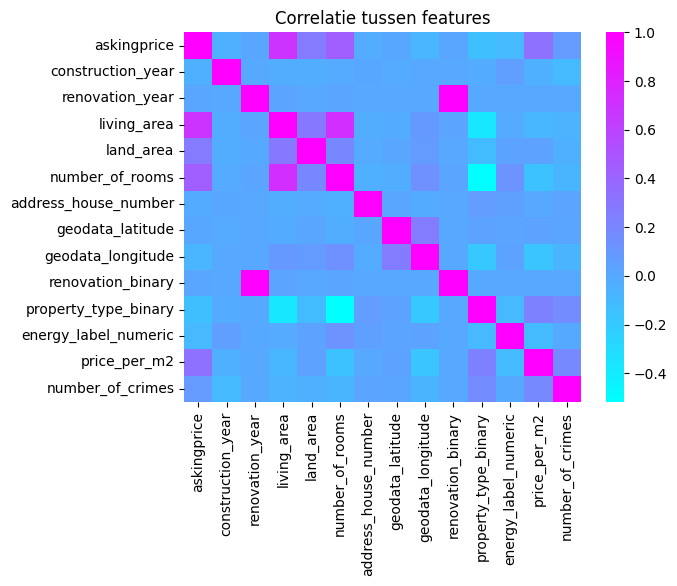

Weights (descending) = [ 2.86984752e+00  4.44989357e+03 -3.60790687e+04]


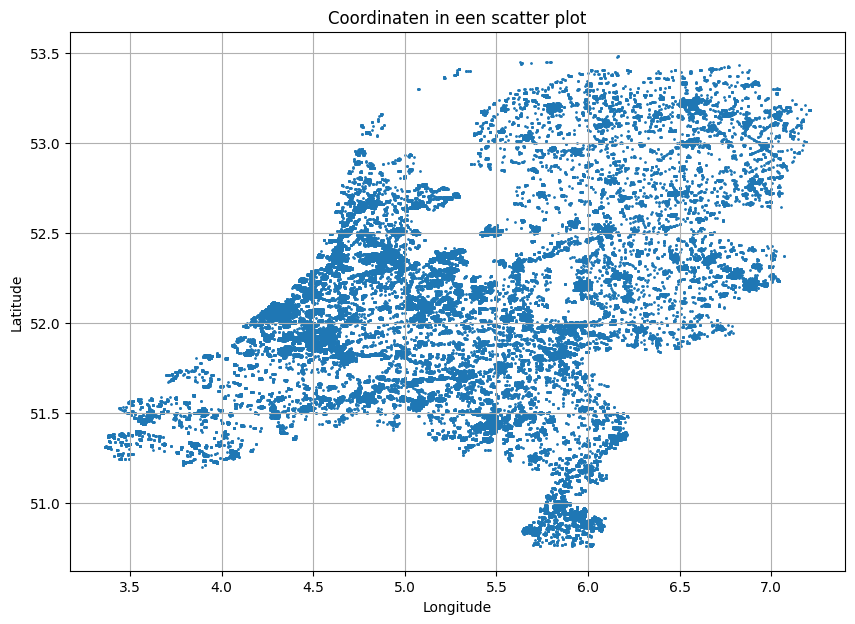


Voorbeeld van welke kolommen geocoding toevoegt:


,sourceUrl,referenceDate,askingprice,property_type,construction_year,renovation_year,living_area,land_area,description,number_of_rooms,particularities,construction_type,energy_label,address_street,address_house_number,address_house_number_add,address_city,address_zip_code,geodata_latitude,geodata_longitude,renovation_binary,property_type_binary,energy_label_numeric,price_per_m2,number_of_crimes,building_type,neighbourhood,suburb,municipality,state
0,https://www.funda.nl/koop/zijderveld/huis-4236...,2023-11-02,685000.0,house,1985.0,0.0,176.0,575.0,"\nRust en ruimte, vrijstaand en duurzaam wo...",7.0,"['air conditioning', 'skylight', 'mechanical v...","['single-family home', 'detached home']",A,'t Werfje,30.0,0,Zijderveld,4122GT,51.94106,5.140427,0.0,0,6.0,3892.045455,4.0,house,None,None,Vijfheerenlanden,Utrecht


In [11]:
visualise_data()

### Resultaten modellen

In [12]:
# Bepaal welke data je wilt gebruiken
df_errors = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2', 'Time'])
df_with_zipcodes = df_koop.dropna(subset=['address_zip_code'], inplace=False)
df_city = df_to_dfCity(df_with_zipcodes, 'Rotterdam')
df_koop10, _ = split_data(df_koop, 0.10)
df_no_outliers = df_percentile(df_with_zipcodes, 0.1, 0.9)

# Bepaal of je ook de modellen wilt gebruiken die lang duren of slechte resultaten hebben
extra_models = False

# Roep alle modellen aan met de parameters en features die je wilt gebruiken
df_nn, df_errors = machine_learning(df=df_city, df_errors=df_errors, model=NearestNeighboursRegressor(radius_km=1.2, use_area=True), k=5, print_amount_of_used_datapoints=False, n_jobs=-1, add_columns=True,
                                  print_data_cleaning=False, print_results=True, to_csv=False)

df_rd, df_errors = machine_learning(df=df_nn, df_errors=df_errors, model=Ridge(alpha=1), k=5, print_amount_of_used_datapoints=False, poly_degree=2, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=True,
                     land_area=True, construction_year=True, renovation=False, energy=False, rooms=True, property_type=False, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_dt, df_errors = machine_learning(df=df_rd, df_errors=df_errors, model=DecisionTreeRegressor(criterion='friedman_mse'), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, tree_depth=0, to_csv=False, dropna_all_features=False, living_area=True,
                     land_area=True, construction_year=True, renovation=False, energy=True, rooms=True, property_type=False, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

mlp_model = MLPRegressor(hidden_layer_sizes=(100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
df_mlp, df_errors = machine_learning(df=df_dt, df_errors=df_errors, model=mlp_model, k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=True, land_area=True,
                                   construction_year=False, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=False, dT=True, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_rf, df_errors = machine_learning(df=df_mlp, df_errors=df_errors, model=RandomForestRegressor(criterion='friedman_mse'), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=True,
                                            land_area=True, construction_year=True, renovation=False, energy=True, rooms=True, property_type=False, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_gb, df_errors = machine_learning(df=df_rf, df_errors=df_errors, model=GradientBoostingRegressor(), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, tree_depth=0, to_csv=False, dropna_all_features=False, living_area=False,
                                            land_area=True, construction_year=False, renovation=False, energy=True, rooms=False, property_type=True, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=True, XGB=False, GBR=False, Bag=False)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=8)
df_xb, df_errors = machine_learning(df=df_gb, df_errors=df_errors, model=xgb_model, k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, tree_depth=0, to_csv=False, dropna_all_features=False, living_area=False,
                                            land_area=True, construction_year=False, renovation=False, energy=True, rooms=False, property_type=False, crime=False, nearN=True, dT=True, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_br, df_errors = machine_learning(df=df_xb, df_errors=df_errors, model=BaggingRegressor(base_estimator=xgb_model), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=True,
                                            land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_svr, df_errors = machine_learning(df=df_br, df_errors=df_errors, model=SVR(), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=True, dropna_all_features=False, living_area=True,
                                                land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_ls, df_errors = machine_learning(df=df_svr, df_errors=df_errors, model=Lasso(alpha=1), k=5, poly_degree=2, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=True,
                                                land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

df_ab, df_errors = machine_learning(df=df_ls, df_errors=df_errors, model=AdaBoostRegressor(), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, tree_depth=0, to_csv=False, dropna_all_features=False, living_area=True,
                                                land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)

if extra_models:
    base_models = [
        ('rd', Ridge(alpha=1)),
        ('dt', DecisionTreeRegressor(criterion='friedman_mse')),
        ('mlp', MLPRegressor(hidden_layer_sizes=(100), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=2000, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)),
        ('rf', RandomForestRegressor(criterion='friedman_mse')),
        ('gb', GradientBoostingRegressor()),
        ('xb', XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=8)),
        ('br', BaggingRegressor(base_estimator=XGBRegressor(n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=8)))
    ]

    df_vo, df_errors = machine_learning(df=df_ab, df_errors=df_errors, model=VotingRegressor(estimators=base_models), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=True, dropna_all_features=False, living_area=False,
                                            land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=False, crime=False, nearN=True)

    df_st, df_errors = machine_learning(df=df_vo, df_errors=df_errors, model=StackingRegressor(estimators=base_models), k=5, n_jobs=-1, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=False,
                                            land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=False, crime=False, nearN=True)

    neural_model = keras.Sequential([layers.Dense(100, activation='relu', input_shape=(8,)), layers.Dense(50), layers.Dense(30), layers.Dense(1)])
    neural_model.compile(optimizer='adam', loss='mean_squared_error')
    df_neural, df_errors = machine_learning(df=df_ab, df_errors=df_errors, model=neural_model, k=5, epochs=100, n_jobs=0, add_columns=True, print_data_cleaning=False, print_results=True, to_csv=False, dropna_all_features=False, living_area=True,
                                                land_area=True, construction_year=True, renovation=True, energy=True, rooms=True, property_type=True, crime=False, nearN=True, dT=False, ridge=False, MLP=False, rF=False, XGB=False, GBR=False, Bag=False)


NearestNeighboursRegressor:
Bias = -0.6756 %
Mean Absolute Error = 17.04 %
Root Mean Squared Error = 22.3934 %
R2 = 0.7826
Execution Time = 6.21 seconds

Ridge:
Bias = 2.9426 %
Mean Absolute Error = 17.8524 %
Root Mean Squared Error = 30.7879 %
R2 = 0.6313
Execution Time = 0.31 seconds

DecisionTreeRegressor:
Bias = 2.0177 %
Mean Absolute Error = 15.6702 %
Root Mean Squared Error = 23.4145 %
R2 = 0.7336
Execution Time = 0.29 seconds

MLPRegressor:
Bias = 0.0151 %
Mean Absolute Error = 15.7797 %
Root Mean Squared Error = 22.9913 %
R2 = 0.7326
Execution Time = 1.17 seconds

RandomForestRegressor:
Bias = 2.27 %
Mean Absolute Error = 12.1181 %
Root Mean Squared Error = 17.8225 %
R2 = 0.843
Execution Time = 4.5 seconds

GradientBoostingRegressor:
Bias = 2.8462 %
Mean Absolute Error = 12.7118 %
Root Mean Squared Error = 18.6632 %
R2 = 0.8078
Execution Time = 2.32 seconds

XGBRegressor:
Bias = 3.1385 %
Mean Absolute Error = 14.4934 %
Root Mean Squared Error = 21.0468 %
R2 = 0.8085
Execution T

### Crimes

#### Land zonder crimes (k=5)

NearestNeighboursRegressor:
Bias = 0.7715 %
Mean Absolute Error = 18.5134 %
Root Mean Squared Error = 27.5873 %
Execution Time = 28.42 seconds

Ridge:
Bias = 4.6655 %
Mean Absolute Error = 18.0628 %
Root Mean Squared Error = 28.2306 %
Execution Time = 2.51 seconds

DecisionTreeRegressor:
Bias = 3.5458 %
Mean Absolute Error = 17.5863 %
Root Mean Squared Error = 31.0647 %
Execution Time = 3.11 seconds

MLPRegressor:
Bias = 7.3359 %
Mean Absolute Error = 19.0858 %
Root Mean Squared Error = 31.1507 %
Execution Time = 32.97 seconds

RandomForestRegressor:
Bias = 3.7685 %
Mean Absolute Error = 13.7533 %
Root Mean Squared Error = 22.3025 %
Execution Time = 45.64 seconds

GradientBoostingRegressor:
Bias = 3.938 %
Mean Absolute Error = 14.0324 %
Root Mean Squared Error = 23.351 %
Execution Time = 15.77 seconds

XGBRegressor:
Bias = 4.2322 %
Mean Absolute Error = 15.5817 %
Root Mean Squared Error = 24.9582 %
Execution Time = 3.95 seconds

BaggingRegressor:
Bias = 3.831 %
Mean Absolute Error = 14.5251 %
Root Mean Squared Error = 22.9695 %
Execution Time = 17.59 seconds

#### Land met crimes (k=5)

NearestNeighboursRegressor:
Bias = 0.7715 %
Mean Absolute Error = 18.5134 %
Root Mean Squared Error = 27.5873 %
Execution Time = 29.29 seconds

Ridge:
Bias = 4.6591 %
Mean Absolute Error = 18.0637 %
Root Mean Squared Error = 28.108 %
Execution Time = 2.83 seconds

DecisionTreeRegressor:
Bias = 3.5242 %
Mean Absolute Error = 18.0155 %
Root Mean Squared Error = 31.0899 %
Execution Time = 3.13 seconds

MLPRegressor:
Bias = -1.3598 %
Mean Absolute Error = 18.8094 %
Root Mean Squared Error = 27.8408 %
Execution Time = 31.03 seconds

RandomForestRegressor:
Bias = 3.7665 %
Mean Absolute Error = 13.8331 %
Root Mean Squared Error = 22.2835 %
Execution Time = 51.26 seconds

GradientBoostingRegressor:
Bias = 3.9923 %
Mean Absolute Error = 14.1241 %
Root Mean Squared Error = 23.4529 %
Execution Time = 15.34 seconds

XGBRegressor:
Bias = 4.2057 %
Mean Absolute Error = 15.5904 %
Root Mean Squared Error = 24.7856 %
Execution Time = 3.55 seconds

BaggingRegressor:
Bias = 3.7674 %
Mean Absolute Error = 14.4664 %
Root Mean Squared Error = 22.5575 %
Execution Time = 16.64 seconds


#### Rotterdam zonder crimes (k=20)

NearestNeighboursRegressor:
Bias = -0.1358 %
Mean Absolute Error = 16.9999 %
Root Mean Squared Error = 22.3226 %
Execution Time = 0.52 seconds

Ridge:
Bias = 3.0201 %
Mean Absolute Error = 17.5957 %
Root Mean Squared Error = 30.5605 %
Execution Time = 0.38 seconds

DecisionTreeRegressor:
Bias = 1.8206 %
Mean Absolute Error = 14.6025 %
Root Mean Squared Error = 23.3517 %
Execution Time = 0.38 seconds

MLPRegressor:
Bias = -3.3599 %
Mean Absolute Error = 15.1821 %
Root Mean Squared Error = 22.3954 %
Execution Time = 0.77 seconds

RandomForestRegressor:
Bias = 2.2607 %
Mean Absolute Error = 11.4182 %
Root Mean Squared Error = 17.3228 %
Execution Time = 2.65 seconds

GradientBoostingRegressor:
Bias = 2.6952 %
Mean Absolute Error = 11.6674 %
Root Mean Squared Error = 17.4097 %
Execution Time = 0.88 seconds

XGBRegressor:
Bias = 2.959 %
Mean Absolute Error = 13.7761 %
Root Mean Squared Error = 20.866 %
Execution Time = 0.58 seconds

BaggingRegressor:
Bias = 2.3741 %
Mean Absolute Error = 11.5333 %
Root Mean Squared Error = 16.9664 %
Execution Time = 4.7 seconds

#### Rotterdam met crimes (k=20)

NearestNeighboursRegressor:
Bias = -0.1358 %
Mean Absolute Error = 16.9999 %
Root Mean Squared Error = 22.3226 %
Execution Time = 0.53 seconds

Ridge:
Bias = 3.0455 %
Mean Absolute Error = 17.6843 %
Root Mean Squared Error = 28.6547 %
Execution Time = 0.38 seconds

DecisionTreeRegressor:
Bias = 1.98 %
Mean Absolute Error = 14.1184 %
Root Mean Squared Error = 23.0637 %
Execution Time = 0.39 seconds

MLPRegressor:
Bias = -1.1051 %
Mean Absolute Error = 14.3789 %
Root Mean Squared Error = 22.3688 %
Execution Time = 0.71 seconds

RandomForestRegressor:
Bias = 2.2233 %
Mean Absolute Error = 11.067 %
Root Mean Squared Error = 16.9411 %
Execution Time = 2.83 seconds

GradientBoostingRegressor:
Bias = 2.5519 %
Mean Absolute Error = 11.3599 %
Root Mean Squared Error = 17.1584 %
Execution Time = 0.93 seconds

XGBRegressor:
Bias = 2.6517 %
Mean Absolute Error = 13.0224 %
Root Mean Squared Error = 20.0158 %
Execution Time = 0.6 seconds

BaggingRegressor:
Bias = 2.3019 %
Mean Absolute Error = 11.2274 %
Root Mean Squared Error = 16.5327 %
Execution Time = 4.87 seconds

### Resultaten (niet gekeken naar crimes, k=100)

KOOP:

NearestNeighboursRegressor:
Bias = 0.9219 %
Mean Absolute Error = 18.0873 %
Root Mean Squared Error = 26.8463 %
Execution Time = 60.09 seconds

Ridge:
Bias = 4.4854 %
Mean Absolute Error = 17.5744 %
Root Mean Squared Error = 27.3685 %
Execution Time = 42.32 seconds

DecisionTreeRegressor:
Bias = 2.5578 %
Mean Absolute Error = 12.7621 %
Root Mean Squared Error = 25.6273 %
Execution Time = 42.11 seconds

MLPRegressor:
Bias = 2.7499 %
Mean Absolute Error = 14.9911 %
Root Mean Squared Error = 25.3079 %
Execution Time = 2515.04 seconds

RandomForestRegressor:
Bias = 3.0146 %
Mean Absolute Error = 11.1457 %
Root Mean Squared Error = 19.4455 %
Execution Time = 678.84 seconds

GradientBoostingRegressor:
Bias = 2.9998 %
Mean Absolute Error = 11.2781 %
Root Mean Squared Error = 19.9976 %
Execution Time = 209.32 seconds

XGBRegressor:
Bias = 3.2229 %
Mean Absolute Error = 12.989 %
Root Mean Squared Error = 22.5155 %
Execution Time = 140.81 seconds

BaggingRegressor:
Bias = 3.095 %
Mean Absolute Error = 12.2355 %
Root Mean Squared Error = 19.5921 %
Execution Time = 1441.18 seconds

VotingRegressor:
Bias = 4.1696 %
Mean Absolute Error = 14.3422 %
Root Mean Squared Error = 23.0441 %
Execution Time = 2681.88 seconds


HUUR:

NearestNeighboursRegressor:
Bias = 3.7612 %
Mean Absolute Error = 21.2472 %
Root Mean Squared Error = 36.3098 %
Execution Time = 2.96 seconds

Ridge:
Bias = 5.7305 %
Mean Absolute Error = 18.8141 %
Root Mean Squared Error = 35.3729 %
Execution Time = 1.82 seconds

DecisionTreeRegressor:
Bias = 5.3507 %
Mean Absolute Error = 19.6664 %
Root Mean Squared Error = 43.3825 %
Execution Time = 1.82 seconds

MLPRegressor:
Bias = 4.8624 %
Mean Absolute Error = 19.6274 %
Root Mean Squared Error = 37.5406 %
Execution Time = 24.88 seconds

RandomForestRegressor:
Bias = 5.4576 %
Mean Absolute Error = 15.9495 %
Root Mean Squared Error = 32.3049 %
Execution Time = 12.81 seconds

GradientBoostingRegressor:
Bias = 4.9457 %
Mean Absolute Error = 16.0555 %
Root Mean Squared Error = 32.3527 %
Execution Time = 4.02 seconds

XGBRegressor:
Bias = 5.4453 %
Mean Absolute Error = 17.8428 %
Root Mean Squared Error = 34.9484 %
Execution Time = 3.12 seconds

BaggingRegressor:
Bias = 5.1907 %
Mean Absolute Error = 16.1764 %
Root Mean Squared Error = 32.0568 %
Execution Time = 21.81 seconds

### Performance

NearestNeighboursRegressor:
Bias = 0.9219 %
Mean Absolute Error = 18.0873 %
Root Mean Squared Error = 26.8463 %
Execution Time = 60.09 seconds

Ridge:
Bias = 4.4854 %
Mean Absolute Error = 17.5744 %
Root Mean Squared Error = 27.3685 %
Execution Time = 42.32 seconds

DecisionTreeRegressor:
Bias = 2.5578 %
Mean Absolute Error = 12.7621 %
Root Mean Squared Error = 25.6273 %
Execution Time = 42.11 seconds

MLPRegressor:
Bias = 2.7499 %
Mean Absolute Error = 14.9911 %
Root Mean Squared Error = 25.3079 %
Execution Time = 2515.04 seconds

RandomForestRegressor:
Bias = 3.0146 %
Mean Absolute Error = 11.1457 %
Root Mean Squared Error = 19.4455 %
Execution Time = 678.84 seconds

GradientBoostingRegressor:
Bias = 2.9998 %
Mean Absolute Error = 11.2781 %
Root Mean Squared Error = 19.9976 %
Execution Time = 209.32 seconds

XGBRegressor:
Bias = 3.2229 %
Mean Absolute Error = 12.989 %
Root Mean Squared Error = 22.5155 %
Execution Time = 140.81 seconds

BaggingRegressor:
Bias = 3.095 %
Mean Absolute Error = 12.2355 %
Root Mean Squared Error = 19.5921 %
Execution Time = 1441.18 seconds

VotingRegressor:
Bias = 4.1696 %
Mean Absolute Error = 14.3422 %
Root Mean Squared Error = 23.0441 %
Execution Time = 2681.88 seconds


HUUR:

NearestNeighboursRegressor:
Bias = 3.7612 %
Mean Absolute Error = 21.2472 %
Root Mean Squared Error = 36.3098 %
Execution Time = 2.96 seconds

Ridge:
Bias = 5.7305 %
Mean Absolute Error = 18.8141 %
Root Mean Squared Error = 35.3729 %
Execution Time = 1.82 seconds

DecisionTreeRegressor:
Bias = 5.3507 %
Mean Absolute Error = 19.6664 %
Root Mean Squared Error = 43.3825 %
Execution Time = 1.82 seconds

MLPRegressor:
Bias = 4.8624 %
Mean Absolute Error = 19.6274 %
Root Mean Squared Error = 37.5406 %
Execution Time = 24.88 seconds

RandomForestRegressor:
Bias = 5.4576 %
Mean Absolute Error = 15.9495 %
Root Mean Squared Error = 32.3049 %
Execution Time = 12.81 seconds

GradientBoostingRegressor:
Bias = 4.9457 %
Mean Absolute Error = 16.0555 %
Root Mean Squared Error = 32.3527 %
Execution Time = 4.02 seconds

XGBRegressor:
Bias = 5.4453 %
Mean Absolute Error = 17.8428 %
Root Mean Squared Error = 34.9484 %
Execution Time = 3.12 seconds

BaggingRegressor:
Bias = 5.1907 %
Mean Absolute Error = 16.1764 %
Root Mean Squared Error = 32.0568 %
Execution Time = 21.81 seconds

In [13]:
visualise_errors(df_errors)
visualise_R2(df_errors)

In [14]:
visualise_execution_times(df_errors)

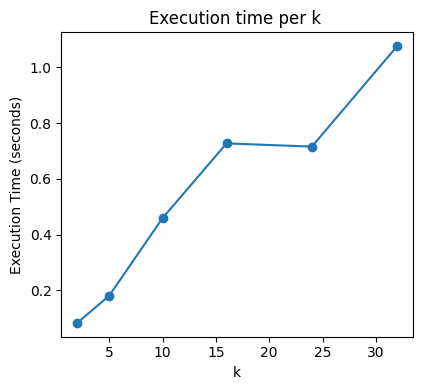

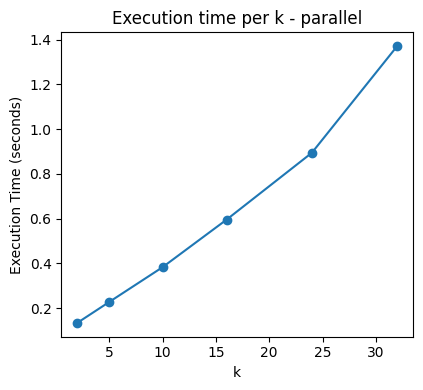

In [15]:
# Laat zien dat parallel computing de modellen sneller kan maken
function_performance_plot(machine_learning, {'df': df_city, 'df_errors': df_errors, 'model': Ridge(), 'n_jobs': 0, 'print_results': False}, [2, 5, 10, 16, 24, 32], 'k')
function_performance_plot(machine_learning, {'df': df_city, 'df_errors': df_errors, 'model': Ridge(), 'n_jobs': -1, 'print_results': False}, [2, 5, 10, 16, 24, 32], 'k', '- parallel')

### Correlatie tussen modellen

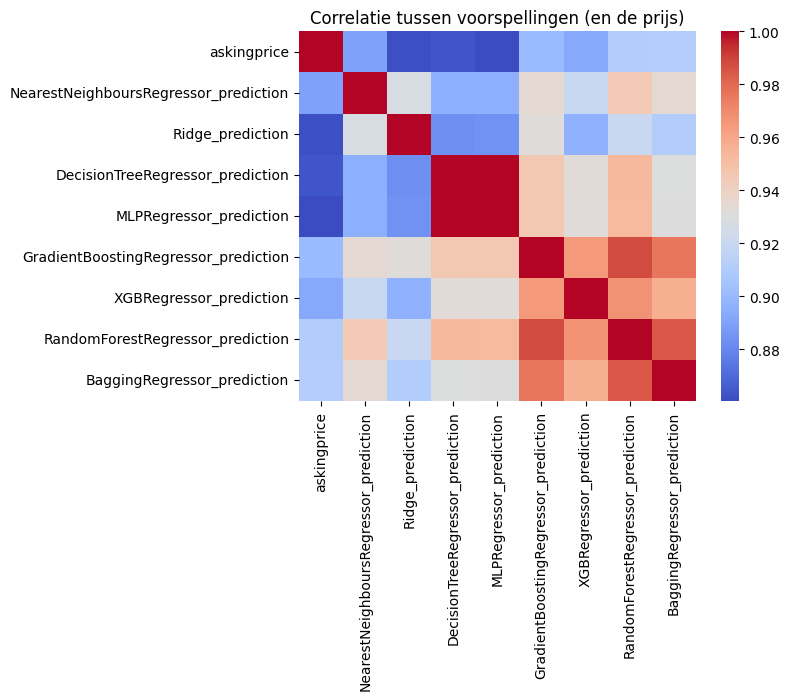

In [16]:
# Laat de correlatie tussen modellen zien
all_model_columns = ['askingprice', 'NearestNeighboursRegressor_prediction', 'Ridge_prediction', 'DecisionTreeRegressor_prediction', 'MLPRegressor_prediction', 'GradientBoostingRegressor_prediction', 'XGBRegressor_prediction', 'RandomForestRegressor_prediction', 'BaggingRegressor_prediction']
sns.heatmap(df_br[all_model_columns].corr(numeric_only=True), cmap='coolwarm')
plt.title('Correlatie tussen voorspellingen (en de prijs)')
plt.show()

### Error modellen

In [17]:
# Laat voor elk model zien voor welke prijsklasse het vaak fout zit
plot_all_errors(error_metric='bias', real_price=True)

# **Oude functies**

### Nearest-neighbours

In [18]:
# Deze versie van nearest-neighbours zit veel tijd in. Echter werkt hij heel anders dan de sklearn functies, dus we hebben er een class van moeten maken
def create_price_series(df_train, lat_min, lat_max, lon_min, lon_max, use_price_per_m2: bool) -> pd.Series:
  df_filtered = df_train[(df_train['geodata_latitude'].between(lat_min, lat_max)) & (df_train['geodata_longitude'].between(lon_min, lon_max))]
  price_column = 'price_per_m2' if use_price_per_m2 else 'askingprice'
  prices_series = df_filtered[price_column]
  return prices_series

def df_with_nearestNeighbours_predictions_column(df: pd.DataFrame, radius_km: float, use_area=True, to_csv=False) -> pd.DataFrame:
  radius_coordinates = km_to_coordinates(radius_km)
  lats = df['geodata_latitude']
  lons = df['geodata_longitude']
  min_lats, max_lats = lats - radius_coordinates, lats + radius_coordinates
  min_lons, max_lons = lons - radius_coordinates, lons + radius_coordinates
  if use_area: df_useful = df[['geodata_latitude', 'geodata_longitude', 'price_per_m2']]
  else: df_useful = df[['geodata_latitude', 'geodata_longitude', 'askingprice']]
  df_sorted = df_useful.sort_values(by=['geodata_latitude', 'geodata_longitude'])

  # De lijn hieronder is de bottleneck die veruit het langst duurt
  pricesPerM2_Series_column = pd.DataFrame(create_price_series(df_sorted.drop(df_sorted.index[i]), lat_min, lat_max, lon_min, lon_max, use_price_per_m2=use_area).values for i, (lat_min, lat_max, lon_min, lon_max) in enumerate(zip(min_lats, max_lats, min_lons, max_lons)))
  meanPricePerM2_column = pricesPerM2_Series_column.mean(axis=1)

  if use_area: df['nearestNeighbours_prediction'] = meanPricePerM2_column * df['living_area'] ** 0.99
  else: df['nearestNeighbours_prediction'] = meanPricePerM2_column

  if to_csv: df.to_csv(f'{df}_with_nearestNeighbours_predictions.csv')

  return df

def nearestNeighbours_predictPrice_seriesArea(prices_per_m2: pd.Series | list, area: float) -> float | None:
  """Voorspelt de prijs van een huis op basis van (de gemiddelde prijs in een Series of list) keer het oppervlakte van het huis"""
  if prices_per_m2.empty:
    return None

  # Berekent de gemiddelde prijs in een Series of lijst
  average_price_per_m2 = np.mean(prices_per_m2)

  # Voorspelt de prijs en doet dit keer een bias_fraction. Deze bias fraction is de constante waarmee vermenigvuldigd moet worden om de bias 0 te maken. Rond af op hele euro's
  predicted_price = average_price_per_m2 * area ** 0.99

  return round(predicted_price, 2)

# Functions to predict price based on nearest neighbours
def nearestNeighbours_predictPrice_coordinatesArea(df_train: pd.DataFrame, lat: float, lon: float, area: float, radius_coordinates: float) -> float | None:
  """Voorspelt de prijs van een huis op een locatie, op basis van de gemiddelde prijs per m2 van de huizen eromheen in een ingevoerde radius
   keer het oppervlakte van het huis dat op de locatie staat"""
  min
  lat_min, lat_max = lat - radius_coordinates, lat + radius_coordinates
  lon_min, lon_max = lon - radius_coordinates, lon + radius_coordinates
  df_useful = df_train[['geodata_latitude', 'geodata_longitude', 'price_per_m2']]
  df_sorted = df_useful.sort_values(by=['geodata_latitude', 'geodata_longitude'])
  prices_per_m2_series = create_price_series(df_sorted, lat_min, lat_max, lon_min, lon_max, use_price_per_m2=True)
  predicted_price = nearestNeighbours_predictPrice_seriesArea(prices_per_m2_series, area)

  if predicted_price:
    return round(predicted_price, 2)

  return None

def nearestNeighbours_predictPrice_index(df: pd.DataFrame, index: int, radius_coordinates: float) -> float | None:
  """Voorspelt de prijs van een huis op basis van de index van de row van de DataFrame"""
  row = df.iloc[index]
  lat, lon = row['geodata_latitude'], row['geodata_longitude']
  area = row['living_area']
  df_train = df.drop(index, inplace=False)
  predicted_price = nearestNeighbours_predictPrice_coordinatesArea(df_train, lat, lon, area, radius_coordinates)
  return predicted_price

def nearestNeighbours_results_index(df: pd.DataFrame, index: int, radius_coordinates: float) -> tuple[int, float, int, int] | tuple[None, None, int, None]:
  row = df.iloc[index]
  real_price = round(row['askingprice'])
  predicted_price = nearestNeighbours_predictPrice_index(df, index, radius_coordinates)
  if not predicted_price:
    return None, None, real_price, None
  error = round(predicted_price - real_price)
  error_percentage = round((error * 100) / real_price, 2)
  return error, error_percentage, real_price, predicted_price

def add_nearestNeighbours_columns_predictionsErrorsBias(df: pd.DataFrame, radius_km: float, use_area: bool = True) -> None:
  df = df_with_nearestNeighbours_predictions_column(df, radius_km, use_area)
  df.loc[df['nearestNeighbours_prediction'].isnull(), ['error', 'error_percentage', 'squared_error', 'squared_error_percentage']] = [None, None, None, None]
  df['error'] = df['nearestNeighbours_prediction'] - df['askingprice']
  df['error_percentage'] = (df['error'] * 100) / df['askingprice']
  df['squared_error'] = df['error'] ** 2
  df['squared_error_percentage'] = df['error_percentage'] ** 2

def nearestNeighbours_trainTest(train: pd.DataFrame, test: pd.DataFrame, radius_km: float) -> tuple[float, float, int, int]:
  lats = test['geodata_latitude']
  lons = test['geodata_longitude']
  radius_coordinates = km_to_coordinates(radius_km)

  min_lats, max_lats = lats - radius_coordinates, lats + radius_coordinates
  min_lons, max_lons = lons - radius_coordinates, lons + radius_coordinates
  train_useful = train[['geodata_latitude', 'geodata_longitude', 'price_per_m2']]
  train_sorted = train_useful.sort_values(by=['geodata_latitude', 'geodata_longitude'])

  pricesPerM2_Series_column = pd.DataFrame(create_price_series(train_sorted, lat_min, lat_max, lon_min, lon_max, use_price_per_m2=True).values for lat_min, lat_max, lon_min, lon_max in zip(min_lats, max_lats, min_lons, max_lons))
  meanPricePerM2_column = pricesPerM2_Series_column.mean(axis=1)
  misses = meanPricePerM2_column.isna().sum()
  hits = len(meanPricePerM2_column) - misses
  predictions_column = meanPricePerM2_column * test['living_area'].values ** 0.99
  errors_column = predictions_column - test['askingprice'].values
  error_percentages_column = (errors_column * 100) / test['askingprice'].values
  abs_error_percentages_column = error_percentages_column.abs()
  MAEP = abs_error_percentages_column.mean()
  mean_bias_percentage = error_percentages_column.mean()

  return MAEP, mean_bias_percentage, hits, misses

# Function to perform multiple tests in parallel
def multiple_splits(df: pd.DataFrame, ratio: float, amount_of_splits: int, radius_km: float) -> tuple[float, float, float, int, int]:
  # Define a helper function to be parallelized
  def test_once(df, ratio, radius_km):
      train, test = split_data(df, ratio)
      return nearestNeighbours_trainTest(train, test, radius_km)

  # Run the tests in parallel
  results = Parallel(n_jobs=-1)(delayed(test_once)(df, ratio, radius_km) for _ in range(amount_of_splits))

  # Unpack the results and compute the average error
  if not results:
      return None

  error_percentages, bias_percentages, hits, misses = zip(*results)
  avg_error_percentage = np.mean(error_percentages)
  avg_bias_percentage = np.mean(bias_percentages)
  total_hits = sum(hits)
  total_misses = sum(misses)

  return avg_error_percentage, avg_bias_percentage, total_hits, total_misses

# Overfitting mogelijk bij toevallig goede verdeling train en test sets
def ideal_radius_trainTest(df: pd.DataFrame, trainTest_ratio: float, radius_km_values: list[float], max_miss_hit_ratio: float) -> tuple[float | None, int, int, float]:
  def test_once(radius_km):
      train, test = split_data(df, trainTest_ratio)
      return nearestNeighbours_trainTest(train, test, radius_km)

  # Run tests for each radius value in parallel
  results = Parallel(n_jobs=-1)(delayed(test_once)(radius_km) for radius_km in radius_km_values)

  # Unpack results once outside the loop
  errors, _, hits, misses = zip(*results)

  # Convert errors, misses, and hits to lists once
  errors = list(errors)
  misses = list(misses)
  hits = list(hits)

  if not errors or not hits:
      return None

  best_radius_km = None
  min_error_percentage = float('inf')
  missHit_ratio_there = None

  # Iterate over the results to find the best radius
  for i in range(len(radius_km_values)):
      error_percentage = errors[i]
      miss = misses[i]
      hit = hits[i]
      miss_hit_ratio = miss / hit
      if miss_hit_ratio < max_miss_hit_ratio and error_percentage < min_error_percentage:
          best_radius_km = radius_km_values[i]
          min_error_percentage = error_percentage
          missHit_ratio_there = miss_hit_ratio

  return best_radius_km, min_error_percentage, missHit_ratio_there

def multiple_tests_performance(df, ratio, i_values):
  results = []

  for i in i_values:
    start_time = time.time()
    try: multiple_splits(df, ratio, i, best_radius_km)
    except: multiple_splits(df, ratio, i, radius_km=1)
    end_time = time.time()
    execution_time = end_time - start_time
    results.append((i, execution_time))

  return results

def nearestNeighbours_analyse(df, city, radius_km, ratio, amount_of_splits, amount_of_tests, min_radius, max_radius, max_missHit_ratio, min_i, max_i, jumps):
  if city:
    df = df_to_dfCity(df, city)
  print('Nearest neighbours analyse:')
  print('Test een random index:')
  random_index = np.random.randint(1, df.shape[0])
  radius_coordinates = km_to_coordinates(radius_km)
  error, error_percentage, real_price, predicted_price = nearestNeighbours_results_index(df, random_index, radius_coordinates)
  if predicted_price:
      print(f'Voorspelde prijs = € {predicted_price:,}')
      print(f'Echte prijs = € {real_price:,}')
      print(f'Error = € {error:,}')
      print(f'Error percentage= {error_percentage:,} %')
      print(f'Used index = {random_index}')
  else:
      print('Geen huizen binnen de radius')
      print(f'Echte prijs = € {real_price:,}')
      print(f'Used index = {random_index}')
  print()
  print('Met de gemiddelde prijs van huizen eromheen:')
  add_nearestNeighbours_columns_predictionsErrorsBias(df, radius_km, use_area=False)
  print(f'Amount of NaN values = {len(df[df["nearestNeighbours_prediction"].isnull()])}')
  print(f'Absolute Error Percentage Bias = {round(np.mean(df["error_percentage"]), 2)} %')
  print(f'Mean Absolute Error Percentage = {round(np.mean(abs(df["error_percentage"])), 2)} %')
  print(f'Root Mean Squared Error Percentage = {round(np.sqrt(np.mean(df["squared_error_percentage"])), 2)} %')
  print()
  print('Met de gemiddelde prijs per m2 van huizen eromheen:')
  add_nearestNeighbours_columns_predictionsErrorsBias(df, radius_km, use_area=True)
  print(f'Amount of NaN values = {len(df[df["nearestNeighbours_prediction"].isnull()])}')
  print(f'Absolute Error Percentage Bias = {round(np.mean(df["error_percentage"]), 2)} %')
  print(f'Mean Absolute Error Percentage = {round(np.mean(abs(df["error_percentage"])), 2)} %')
  print(f'Root Mean Squared Error Percentage = {round(np.sqrt(np.mean(df["squared_error_percentage"])), 2)} %')
  print()
  train_ppm2_apeldoorn, test_ppm2_apeldoorn = split_data(df, ratio)
  MAE, bias, hits, misses = nearestNeighbours_trainTest(train_ppm2_apeldoorn, test_ppm2_apeldoorn, radius_km)
  print('Gebaseert op een portie van de dataset en 1 split:')
  print(f'error = {MAE} %')
  print(f'hits = {hits:,}')
  print(f'misses = {misses:,}')
  print(f'bias = {bias:,} %')
  print()
  koop_error, koop_bias, koop_hits, koop_misses = multiple_splits(df, ratio, amount_of_splits, radius_km)
  print(f'Gebaseert op een gedeelte van de dataset en {amount_of_splits} splits:')
  print(f'error = {koop_error} %')
  print(f'bias = {koop_bias} %')
  print(f'hits = {koop_hits:,}')
  print(f'misses = {koop_misses:,}')
  print()
  radius_km_values = np.linspace(min_radius, max_radius, amount_of_tests)
  best_radius_km, error_percentage, missHit_ratio = ideal_radius_trainTest(df, ratio, radius_km_values, max_missHit_ratio)
  print(f'Gebaseert op {amount_of_tests} tests tussen de {min_radius} and {max_radius} km')
  print(f'Best radius = {best_radius_km}')
  print(f'The error there is = {error_percentage} %')
  print(f'The hit-miss ratio with that value are = {missHit_ratio}')
  print()
  print('Geoptimaliseerde resultaten:')
  add_nearestNeighbours_columns_predictionsErrorsBias(df, best_radius_km, use_area=True)
  print(f'Amount of NaN values = {len(df[df["nearestNeighbours_prediction"].isnull()])}')
  print(f'Absolute Error Percentage Bias = {round(np.mean(df["error_percentage"]), 2)} %')
  print(f'Mean Absolute Error Percentage = {round(np.mean(abs(df["error_percentage"])), 2)} %')
  print(f'Root Mean Squared Error Percentage = {round(np.sqrt(np.mean(df["squared_error_percentage"])), 2)} %')
  print()
  i_values = np.arange(min_i, max_i, jumps)
  results = multiple_tests_performance(df, ratio, i_values)
  i_values, execution_times = zip(*results)
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 2)
  plt.plot(i_values, execution_times, marker='o')
  plt.title('Execution Time vs. i')
  plt.xlabel('i')
  plt.ylabel('Execution Time (seconds)')
  plt.tight_layout()
  plt.show()

### Decision Tree

In [19]:
# De originele versie van de beslisboom gebruikte geen regressie. Hier zat veel tijd in

# functie om categorieën van een variabele aan te maken
def create_category(df_decision_tree, num_categories, column_name):
    name =f"{column_name}{'_categories'}"

    # Create a new column 'construction_category' based on quantiles
    df_decision_tree[name] = pd.qcut(df_decision_tree[column_name], q=num_categories, labels=False)

    category_ranges = df_decision_tree.groupby(name)[column_name].agg(['min', 'max'])

    return df_decision_tree, category_ranges

def create_category_with_ranges(df_decision_tree, category_ranges, column_name):
    name = f"{column_name}_categories"
    df_decision_tree[name] = pd.cut(df_decision_tree[column_name], bins=category_ranges, labels=False)
    return df_decision_tree

def ranges_to_rangesList(ranges: pd.DataFrame) -> list[int]:
    return [ranges['min'].iloc[0]] + ranges['max'].iloc[:-1].tolist() + [ranges['max'].iloc[-1]]

def old_decision_tree_model(df_decision_tree_ready):
  y = df_decision_tree_ready['price_per_m2_categories']
  X = df_decision_tree_ready.drop(columns=['price_per_m2_categories'])

  clf = tree.DecisionTreeClassifier()
  clf = clf.fit(X, y)
  tree.plot_tree(clf)

  train_decision_tree, test_decision_tree = split_data(df_decision_tree_ready, 0.7)

  # Assuming df_decision_tree_ready is your feature matrix and 'price_per_m2_categories' is the target variable
  y = train_decision_tree['price_per_m2_categories']
  X = train_decision_tree.drop(columns=['price_per_m2_categories'])

  # Create and fit the decision tree classifier
  clf = tree.DecisionTreeClassifier(max_depth = 5)
  clf = clf.fit(X, y)

  # Set the size of the figure
  plt.figure(figsize=(20, 10))  # You can adjust the width and height as needed

  # Plot the decision tree
  tree.plot_tree(clf, filled=True, feature_names=X.columns, class_names=[str(i) for i in clf.classes_], rounded=True, fontsize=8, max_depth=8)

  # Show the plot
  plt.show()

  # test if the accuracy on the actual trainsingsdata is good
  X_train = train_decision_tree.drop(columns=['price_per_m2_categories'])
  predictions_train = clf.predict(X_train)
  train_decision_tree['predictions_train'] = predictions_train
  correct_predictions = sum(train_decision_tree['predictions_train'] == train_decision_tree['price_per_m2_categories'])
  accuracy = correct_predictions / len(train_decision_tree) * 100
  print(f'Accuracy train: {accuracy:.2f}%')
  print(train_decision_tree)

  # testing on test data
  X_test = test_decision_tree.drop(columns=['price_per_m2_categories'])
  predictions = clf.predict(X_test)
  test_decision_tree['predictions'] = predictions
  print(test_decision_tree)

  correct_predictions = sum(test_decision_tree['predictions'] == test_decision_tree['price_per_m2_categories'])

  # Calculate accuracy
  accuracy = correct_predictions / len(test_decision_tree) * 100

  # Print or use the accuracy as needed
  print(f'Accuracy: {accuracy:.2f}%')

  # numbers higher
  count_higher = (test_decision_tree['predictions'] > test_decision_tree['price_per_m2_categories']).sum()
  print(f'Predicted higher = {count_higher}')

  # numbers lower
  count_lower = (test_decision_tree['predictions'] < test_decision_tree['price_per_m2_categories']).sum()
  print(f'Predicted lower = {count_lower}')

  def decision_tree_regressor_errors_split(df, ratio=0.7, visualise=False, construction_year=True, renovation_year=True, energy_label=True, number_of_rooms=True, property_type=True, nearestNeighbours=True):
    df = df.copy()
    # Deze lijn kan eruit als er een nieuwe versie is van df_koop_with_nearestNeighbours_predictions en woninginbraken
    df = delete_certain_values(df, 'construction_year' , 1180.0)
    df = delete_certain_values(df, 'construction_year' , 1076.0)
    df = delete_certain_values(df, 'construction_year' , 1005.0)
    df = delete_certain_values(df, 'property_type', 'other offer')

    # Dropping all entries with missing values of features we are looking at
    columns_to_keep = []
    columns_to_drop_na = []

    if construction_year:
        columns_to_keep.append('construction_year')
        columns_to_drop_na.append('construction_year')

    if renovation_year:
        columns_to_keep.append('renovation_year')

    if energy_label:
        columns_to_keep.append('energy_label')
        columns_to_drop_na.append('energy_label')

    if number_of_rooms:
        columns_to_keep.append('number_of_rooms')
        columns_to_drop_na.append('number_of_rooms')

    if property_type:
        columns_to_keep.append('property_type')
        columns_to_drop_na.append('property_type')

    if nearestNeighbours:
        df['nn_prediction_per_m2'] = df['NearestNeighboursRegressor_prediction'] / df['living_area']
        columns_to_keep.append('nn_prediction_per_m2')
        columns_to_drop_na.append('nn_prediction_per_m2')

    columns_to_keep.append('price_per_m2')
    columns_to_drop_na.append('price_per_m2')

    df = df.loc[:, columns_to_keep]

    # Drop rows with NaN values in the specified columns
    df.dropna(subset=columns_to_drop_na)

    if construction_year:
        # separating the construction_years into categories
        construction_year_categories, construction_category_ranges = create_category(df, 5, 'construction_year')

    if energy_label:
        # separating the energylabels into categories, see the label_mapping for corresponding numbers to values.
        label_mapping = {'A+++++': 1, 'A++++' : 2, 'A+++' : 3, 'A++': 4, 'A_PLUS_PLUS': 4,'A_PLUS': 5, 'A+': 5, 'A': 6, 'B': 7, 'C': 8, 'D': 9, 'E': 10, 'F': 11, 'G': 12}
        df['energy_label_numeric'] = df['energy_label'].replace(label_mapping)
        energy_label_categories, energy_label_ranges = create_category(df, 5, 'energy_label_numeric')

    if renovation_year:
        # separating the yes or no renovation into categories
        df['renovation_year'] = df['renovation_year'].fillna(0)
        df['renovation_year'] = df['renovation_year'].apply(lambda x: 1 if x != 0 else x)

    if number_of_rooms:
        # seperating the numbers of rooms into 5 categories
        number_of_rooms_categories, number_of_rooms_ranges = create_category(df, 5, 'number_of_rooms')

    if property_type:
        # the property types are already split into 2 categories
        df['property_type'] = df['property_type'].replace({'house': 0, 'apartment': 1})
        unique_property_types = df['property_type'].unique()

    # the prices into catergoies
    price_per_m2_categories, price_per_m2_ranges = create_category(df, 5, 'price_per_m2')

    if nearestNeighbours:
        nn_prediction_ranges = price_per_m2_ranges.rename_axis('nn_prediction_per_m2_categories')
        nn_prediction_ranges_list = ranges_to_rangesList(nn_prediction_ranges)
        nn_prediction_categories = create_category_with_ranges(df, nn_prediction_ranges_list, 'nn_prediction_per_m2')

    columns_regressor = [w.replace('energy_label', 'energy_label_numeric') for w in columns_to_keep]
    df_decision_tree_regressor = df.loc[:, columns_regressor]

    if visualise:
        if construction_year:
            print('construction year categories')
            print(construction_category_ranges)
            print()
        if energy_label:
            print('energy label categories')
            print()
            print('label mapping into numbers')
            print(label_mapping)
            print(energy_label_ranges)
            print()
        if renovation_year:
            print('revonation_year categories')
            print(df['renovation_year'].unique())
        if number_of_rooms:
            print('number_of_rooms categories')
            print(number_of_rooms_ranges)
            print()
        if property_type:
            print(unique_property_types)
        if nearestNeighbours:
            print('nn_prediction_per_m2')
            print(nn_prediction_ranges)
            print('\n')
        print('price_per_m2')
        print(price_per_m2_ranges)
        print('\n')

    train_regressor, test_regressor = split_data(df_decision_tree_regressor, ratio)

    # splitting the trainingsdata and the target
    X_train = train_regressor.drop(columns=['price_per_m2'])
    y_train = train_regressor['price_per_m2']

    X_test = test_regressor.drop(columns=['price_per_m2'])
    y_test = test_regressor['price_per_m2']

    # fitting the regressor on the trainingsdata
    regressor = DecisionTreeRegressor()

    regressor.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = regressor.predict(X_test)

    # add column with predictions
    test_regressor['predictions_test'] = y_pred

    # Evaluate the performance (e.g., mean squared error)
    test_regressor['error'] = test_regressor['predictions_test'] - test_regressor['price_per_m2']
    test_regressor['error_percentage'] = (test_regressor['error'] * 100) / test_regressor['price_per_m2']
    test_regressor['squared_error'] = test_regressor['error'] ** 2
    test_regressor['squared_error_percentage'] = test_regressor['error_percentage'] ** 2

    print('Decision tree regressor:')
    print(f'Mean Absolute Error Percentage = {round(np.mean(abs(test_regressor["error_percentage"])), 2)} %')
    print(f'Root Mean Squared Error Percentage = {round(np.sqrt(np.mean(test_regressor["squared_error_percentage"])), 2)} %')

    if visualise:
        # Set the size of the figure
        plt.figure(figsize=(15, 8))

        # Plot the decision tree
        tree.plot_tree(regressor, filled=True, feature_names=X_train.columns, rounded=True, fontsize=6, max_depth = 5)

        # Show the plot
        plt.show()

### NLP

In [20]:
# Dit model kijkt in de beschrijvingen van de huizen en vindt welke woorden de prijs het meest beinvloeden (deze versie is niet helemaal af)
def nlp_all_points(df: pd.DataFrame):

    df['price_per_m2'] = df['askingprice'] / df['living_area']
    # wellicht dat een andere
    radius_coordinates = km_to_coordinates(1)
    df['avg_ppm2_area'] = nearestNeighbours_predictPrice_coordinatesArea(df, df['geodata_latitude'].iloc[0], df['geodata_longitude'].iloc[0], df['living_area'].iloc[0], radius_coordinates)[1]
    df['deviation_avg'] = df['price_per_m2'] - df['avg_ppm2_area']
    print(np.mean(df['deviation_avg']))
    #
    vectorizer = TfidfVectorizer()
    # TODO: stopwoordenlijst
    X = vectorizer.fit_transform(df['description'])
    X_train, X_test, y_train, y_test = train_test_split(X, df['deviation_avg'], test_size=0.2, random_state=42)

    # Train
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    difference = (100 * predictions) / y_test

    mse = mean_squared_error(y_test, predictions)
    print("Mean Squared Error:", mse)

    return np.mean(abs(difference-100))

## **Extra Visualisaties**

#### Nearest-neighbours

Nearest neighbours analyse:
Test een random index:
Voorspelde prijs = € 517,315.7
Echte prijs = € 607,000
Error = € -89,684
Error percentage= -14.77 %
Used index = 274

Met de gemiddelde prijs van huizen eromheen:
Amount of NaN values = 0
Absolute Error Percentage Bias = 18.36 %
Mean Absolute Error Percentage = 37.78 %
Root Mean Squared Error Percentage = 55.44 %

Met de gemiddelde prijs per m2 van huizen eromheen:
Amount of NaN values = 0
Absolute Error Percentage Bias = 0.19 %
Mean Absolute Error Percentage = 17.53 %
Root Mean Squared Error Percentage = 24.18 %

Gebaseert op een portie van de dataset en 1 split:
error = 17.38697528570697 %
hits = 128
misses = 0
bias = -1.720039099127033 %

Gebaseert op een gedeelte van de dataset en 16 splits:
error = 18.281698057129148 %
bias = 0.11324091444733123 %
hits = 2,048
misses = 0

Gebaseert op 16 tests tussen de 0.3 and 0.7 km
Best radius = 0.6466666666666666
The error there is = 15.366237708962295 %
The hit-miss ratio with that value are 

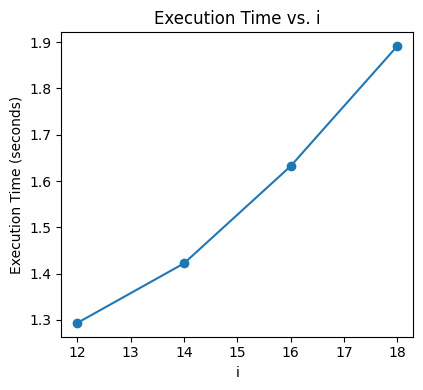

In [21]:
# Laat zien wat de originele nearest-neighbours functie allemaal kon en liet zien
nearestNeighbours_analyse(df=df_koop, city='Apeldoorn', radius_km=1, ratio=0.8, amount_of_splits=16, amount_of_tests=16, min_radius=0.3, max_radius=0.7, max_missHit_ratio=0.0001, min_i=12, max_i=20, jumps=2)

#### NLP

In [22]:
# Deze hebben we niet afgemaakt, omdat wij niet verwachten dat het de voorspellingen beter zal maken
try: nlp_all_points(df_koop)
except: pass